In [15]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:1000]
y_train = y_train[:1000]
X_test = X_test[:200]
y_test = y_test[:200]

mnist_classes_count = 10

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 784))
X_test = scaler.transform(X_test.reshape(-1, 784)) # для подачи в нейронную сеть их необходимо преобразовать в одномерные векторы

# One-hot encoding меток
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

class ActivationFunction:
    def __init__(self):
        pass

    def activate(self, z):
        return NotImplementedError

    def derivative(self, z):
        raise NotImplementedError

class ReLU(ActivationFunction):
    def activate(self, z):
        return np.maximum(0, z)

    def derivative(self, z):
        return np.where(z > 0, 1, 0)

class GELU(ActivationFunction):
    def activate(self, z):
        return 0.5 * z * (1 + np.tanh(np.sqrt(2/np.pi) * (z + 0.044715 * z**3)))

    def derivative(self, z):
        tanh = np.tanh(np.sqrt(2/np.pi) * (z + 0.044715 * z**3))
        derivative = 0.5 * (1 + tanh) + 0.5 * z * (np.sqrt(2/np.pi) * (1 + 0.13403 * z**2) * (1 - tanh**2))
        return derivative

class Swish(ActivationFunction):
    def activate(self, z):
        beta = 1  # Можно вручную поменять
        return z * (1 / (1 + np.exp(-beta * z)))

    def derivative(self, z):
        beta = 1
        sigmoid = 1 / (1 + np.exp(-beta * z))
        return sigmoid + z * sigmoid * (1 - sigmoid)

class Softplus(ActivationFunction):
    def activate(self, z):
        return np.log(1 + np.exp(z))

    def derivative(self, z):
        return np.exp(z) / (1 + np.exp(z))

class Softmax(ActivationFunction):
    def activate(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def derivative(self, z):
        s = self.activate(z)
        return s * (1 - s)

class NeuralNetwork:
    def __init__(self, input_size, layer_config):
        self.layers = []
        self.weights = []
        self.biases = []
        self.accuracy_history = []

        prev_size = input_size
        for config in layer_config:
            activation = config['activation']()
            self.layers.append({
                'size': config['size'],
                'activation': activation,
                'z': None,
                'a': None
            })
            current_size = config['size']
            self.weights.append(np.random.randn(prev_size, current_size) * 0.01)
            self.biases.append(np.zeros((1, current_size)))
            prev_size = current_size

    def forward_propagation(self, X):
        a = X
        for i, layer in enumerate(self.layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = layer['activation'].activate(z)
            layer['z'] = z
            layer['a'] = a
        return a

    def backward_propagation(self, X, y, learning_rate):
        # Вычисляем ошибку на выходном слое
        dz = (self.layers[-1]['a'] - y) / X.shape[0] # в качестве ошибки используем
        # категориальную кросс-энтропию
        # если почитать в источниках, то при SoftMax
        # производная кросс-энтропии равна $p_i - y_i$
    
        # Проходим по всем слоям в обратном порядке
        for i in reversed(range(len(self.layers))):
            # Вычисляем градиент весов
            dW = np.dot(self.layers[i-1]['a'].T, dz) if i != 0 else np.dot(X.T, dz)
            # Вычисляем градиент смещений
            db = np.sum(dz, axis=0, keepdims=True)
    
            # Если это не первый слой, передаем ошибку на предыдущий слой
            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.layers[i-1]['activation'].derivative(self.layers[i-1]['z'])
    
            # Обновляем веса и смещения
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db

    def train(self, X, y, learning_rate, epochs):
        self.accuracy_history = []
        for epoch in range(epochs):
            output = self.forward_propagation(X)
            self.backward_propagation(X, y, learning_rate)
            self.accuracy_history.append(self.accuracy(y_test, self.predict(X_test)))

    def predict(self, X):
        output = self.forward_propagation(X)
        return np.argmax(output, axis=1)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def get_accuracy_history(self):
        return self.accuracy_history

input_size = X_train.shape[1]
layer_config = [
    {'size': 128, 'activation': ReLU},
    {'size': 64, 'activation': GELU},
    {'size': mnist_classes_count, 'activation': Softmax} 
]

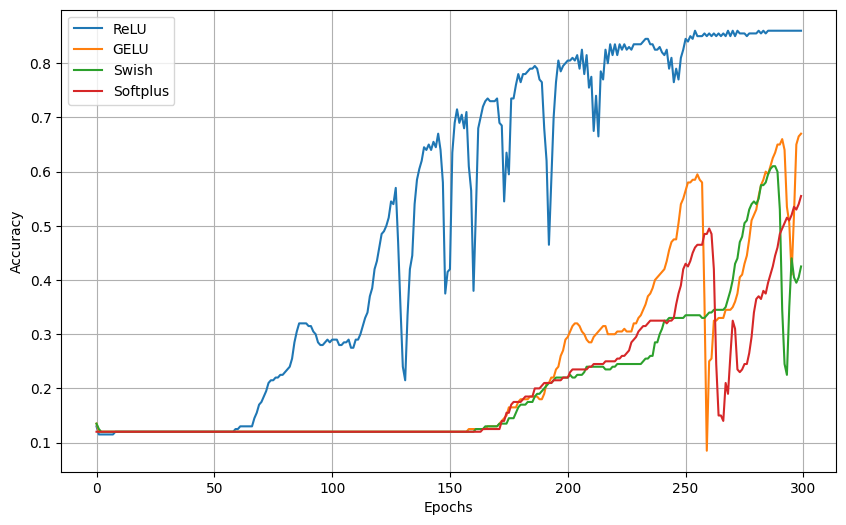

In [17]:
import matplotlib.pyplot as plt

activation_functions = [ReLU, GELU, Swish, Softplus]
results = {}

for activation in activation_functions:
    layer_config[0]['activation'] = activation
    layer_config[1]['activation'] = activation
    nn = NeuralNetwork(input_size, layer_config)
    nn.train(X_train, y_train_encoded, learning_rate=0.3, epochs=300)
    accuracy_history = nn.get_accuracy_history()
    results[activation.__name__] = accuracy_history

plt.figure(figsize=(10, 6))
for activation, accuracy_history in results.items():
    plt.plot(accuracy_history, label=activation)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()